In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlalchemy

from dtaidistance import clustering
from dtaidistance import dtw
from scipy import stats

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot

In [2]:
plt.style.use('ggplot')
sns.set_style('white')

In [3]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [4]:
num_weeks = 6
sell_data = load_transform_combine(num_weeks, connection)
xticks = sell_data['weekday_observed'].unique()

trends = pivot(sell_data)
trends = trends.to_numpy()

In [5]:
# standardize using z-score
trends = stats.zscore(trends)
num_trends = trends.shape[0]

distances = np.zeros((num_trends, num_trends))

# compute pairwise distances, build complete graph, save distances
for x, y in np.ndindex(distances.shape):
    if (x > y):
        distance = dtw.distance(trends[x], trends[y])
        distances[x][y] = distance
        distances[y][x] = distance

In [6]:
# visualize pairwise distances
distances_df = pd.DataFrame(distances)
distances_df.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.000000,3.381113,2.541638,4.626922,4.671214,0.988318,3.508800,5.772071,5.987850,3.460098,...,4.017636,3.681440,3.220823,4.821636,3.912701,3.271162,5.586418,3.472377,2.745186,5.571289
1,3.381113,0.000000,3.473593,2.722177,3.607765,3.275321,2.695675,2.649352,3.054180,1.878124,...,0.737309,1.796548,1.728546,2.657734,1.954615,2.539007,2.721540,1.768022,2.188332,2.540006
2,2.541638,3.473593,0.000000,3.653673,3.130107,2.223000,2.183362,5.566774,5.811340,3.263377,...,4.092732,3.807557,3.294195,4.278199,4.036488,2.290179,5.579739,3.697594,2.661340,5.460920
3,4.626922,2.722177,3.653673,0.000000,1.703505,4.119392,1.409226,2.811323,3.091277,2.446800,...,2.910852,3.494245,3.273320,2.527323,3.591651,2.465362,3.015742,3.578595,3.415269,2.956883
4,4.671214,3.607765,3.130107,1.703505,0.000000,4.151624,1.565068,4.303155,4.054167,2.441790,...,4.217720,4.417619,4.048820,4.543139,4.586490,1.787027,3.671121,4.497291,4.175527,4.213215


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:00<00:00, 12096.40it/s]


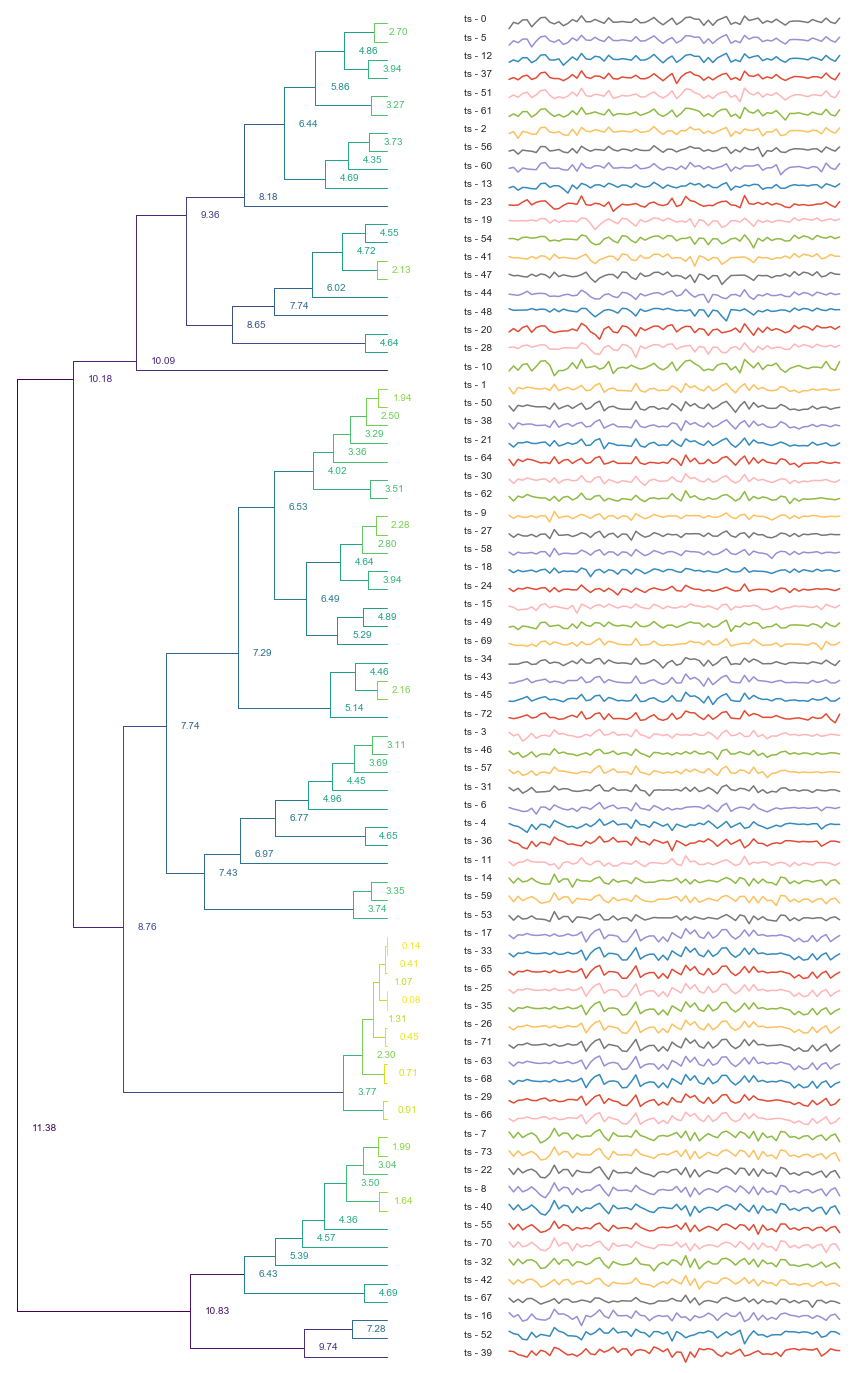

In [13]:
# dtaidistance clustering from the documentation
model1 = clustering.Hierarchical(dtw.distance_matrix_fast, {})
model2 = clustering.HierarchicalTree(model1, show_ts_label=True)
cluster_idx = model2.fit(distances)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 25))
show_ts_label = lambda idx: "ts - " + str(idx)
model2.plot(axes=ax, show_ts_label=show_ts_label,
           show_tr_label=True, ts_label_margin=-10,
           ts_left_margin=10, ts_sample_length=1)
plt.show()

In [ ]:
np.save('data/distances', distances)